# Machine Learning Trading Bot Tuned

#### Tune the Baseline Trading Algorithm

In this section, you’ll tune, or adjust, the model’s input features to find the parameters that result in the best trading outcomes. (You’ll choose the best by comparing the cumulative products of the strategy returns.) To do so, complete the following steps:

1. Tune the training algorithm by adjusting the size of the training dataset. To do so, slice your data into different periods. Rerun the notebook with the updated parameters, and record the results in your `README.md` file. Answer the following question: What impact resulted from increasing or decreasing the training window?

> **Hint** To adjust the size of the training dataset, you can use a different `DateOffset` value&mdash;for example, six months. Be aware that changing the size of the training dataset also affects the size of the testing dataset.

2. Tune the trading algorithm by adjusting the SMA input features. Adjust one or both of the windows for the algorithm. Rerun the notebook with the updated parameters, and record the results in your `README.md` file. Answer the following question: What impact resulted from increasing or decreasing either or both of the SMA windows?

3. Choose the set of parameters that best improved the trading algorithm returns. Save a PNG image of the cumulative product of the actual returns vs. the strategy returns, and document your conclusion in your `README.md` file.


In [1]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report

---

## Establish a Baseline Performance

In this section, you’ll run the provided starter code to establish a baseline performance for the trading algorithm. To do so, complete the following steps.

Open the Jupyter notebook. Restart the kernel, run the provided cells that correspond with the first three steps, and then proceed to step four. 


### Step 1: Import the OHLCV dataset into a Pandas DataFrame.

In [2]:
# Import the OHLCV dataset into a Pandas Dataframe
ohlcv_df = pd.read_csv(
    Path("./Resources/emerging_markets_ohlcv.csv"), 
    index_col='date', 
    infer_datetime_format=True, 
    parse_dates=True
)

# Review the DataFrame
ohlcv_df.head()

C:\Users\Asia\AppData\Local\Temp\ipykernel_15124\566489611.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  ohlcv_df = pd.read_csv(
C:\Users\Asia\AppData\Local\Temp\ipykernel_15124\566489611.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ohlcv_df = pd.read_csv(


,open,high,low,close,volume
date,,,,,
2015-01-21 09:30:00,23.83,23.83,23.83,23.83,100
2015-01-21 11:00:00,23.98,23.98,23.98,23.98,100
2015-01-22 15:00:00,24.42,24.42,24.42,24.42,100
2015-01-22 15:15:00,24.42,24.44,24.42,24.44,200
2015-01-22 15:30:00,24.46,24.46,24.46,24.46,200


In [3]:
# Filter the date index and close columns
signals_df = ohlcv_df.loc[:, ["close"]]

# Use the pct_change function to generate returns from close prices
signals_df["Actual Returns"] = signals_df["close"].pct_change()

# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns
date,,
2015-01-21 11:00:00,23.98,0.006295
2015-01-22 15:00:00,24.42,0.018349
2015-01-22 15:15:00,24.44,0.000819
2015-01-22 15:30:00,24.46,0.000818
2015-01-26 12:30:00,24.33,-0.005315


,close,Actual Returns
date,,
2021-01-22 09:30:00,33.27,-0.006866
2021-01-22 11:30:00,33.35,0.002405
2021-01-22 13:45:00,33.42,0.002099
2021-01-22 14:30:00,33.47,0.001496
2021-01-22 15:45:00,33.44,-0.000896


## Step 2: Generate trading signals using short- and long-window SMA values. 

In [4]:
# Set the short window and long window
short_window =7
long_window = 50

# Generate the fast and slow simple moving averages (4 and 50 days, respectively)
signals_df['SMA_Fast'] = signals_df['close'].rolling(window=short_window).mean()
signals_df['SMA_Slow'] = signals_df['close'].rolling(window=long_window).mean()

signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow
date,,,,
2015-02-23 15:30:00,24.46,0.000818,24.477143,24.2200
2015-02-23 15:45:00,24.49,0.001226,24.472857,24.2302
2015-02-24 10:45:00,24.72,0.009392,24.507143,24.2362
2015-02-24 11:00:00,24.74,0.000809,24.541429,24.2422
2015-02-24 12:15:00,24.70,-0.001617,24.570000,24.2470


,close,Actual Returns,SMA_Fast,SMA_Slow
date,,,,
2021-01-22 09:30:00,33.27,-0.006866,33.065714,31.2232
2021-01-22 11:30:00,33.35,0.002405,33.165714,31.2848
2021-01-22 13:45:00,33.42,0.002099,33.247143,31.3480
2021-01-22 14:30:00,33.47,0.001496,33.292857,31.4132
2021-01-22 15:45:00,33.44,-0.000896,33.345714,31.4768


In [5]:
# Initialize the new Signal column
signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = -1

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
date,,,,,
2015-02-23 15:30:00,24.46,0.000818,24.477143,24.2200,1.0
2015-02-23 15:45:00,24.49,0.001226,24.472857,24.2302,1.0
2015-02-24 10:45:00,24.72,0.009392,24.507143,24.2362,1.0
2015-02-24 11:00:00,24.74,0.000809,24.541429,24.2422,1.0
2015-02-24 12:15:00,24.70,-0.001617,24.570000,24.2470,-1.0


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
date,,,,,
2021-01-22 09:30:00,33.27,-0.006866,33.065714,31.2232,-1.0
2021-01-22 11:30:00,33.35,0.002405,33.165714,31.2848,1.0
2021-01-22 13:45:00,33.42,0.002099,33.247143,31.3480,1.0
2021-01-22 14:30:00,33.47,0.001496,33.292857,31.4132,1.0
2021-01-22 15:45:00,33.44,-0.000896,33.345714,31.4768,-1.0


In [6]:
signals_df['Signal'].value_counts()

Signal
 1.0    2404
-1.0    1869
Name: count, dtype: int64

In [7]:
# Calculate the strategy returns and add them to the signals_df DataFrame
signals_df['Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2015-02-23 15:30:00,24.46,0.000818,24.477143,24.2200,1.0,NaN
2015-02-23 15:45:00,24.49,0.001226,24.472857,24.2302,1.0,0.001226
2015-02-24 10:45:00,24.72,0.009392,24.507143,24.2362,1.0,0.009392
2015-02-24 11:00:00,24.74,0.000809,24.541429,24.2422,1.0,0.000809
2015-02-24 12:15:00,24.70,-0.001617,24.570000,24.2470,-1.0,-0.001617


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2021-01-22 09:30:00,33.27,-0.006866,33.065714,31.2232,-1.0,-0.006866
2021-01-22 11:30:00,33.35,0.002405,33.165714,31.2848,1.0,-0.002405
2021-01-22 13:45:00,33.42,0.002099,33.247143,31.3480,1.0,0.002099
2021-01-22 14:30:00,33.47,0.001496,33.292857,31.4132,1.0,0.001496
2021-01-22 15:45:00,33.44,-0.000896,33.345714,31.4768,-1.0,-0.000896


<Axes: xlabel='date'>

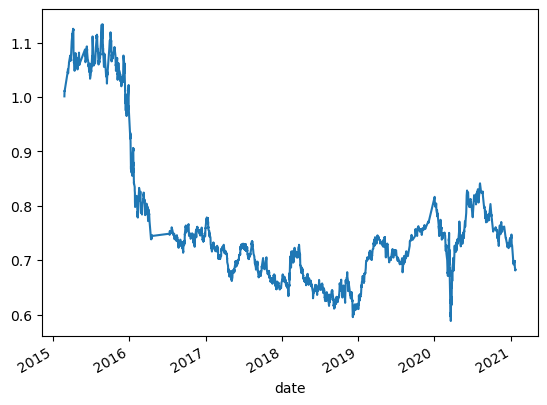

In [8]:
# Plot Strategy Returns to examine performance
(1 + signals_df['Strategy Returns']).cumprod().plot()

### Step 3: Split the data into training and testing datasets.

In [9]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = signals_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()

# Review the DataFrame
X.head()

,SMA_Fast,SMA_Slow
date,,
2015-02-23 15:45:00,24.477143,24.2200
2015-02-24 10:45:00,24.472857,24.2302
2015-02-24 11:00:00,24.507143,24.2362
2015-02-24 12:15:00,24.541429,24.2422
2015-02-24 15:45:00,24.570000,24.2470


In [10]:
# Create the target set selecting the Signal column and assiging it to y
y = signals_df['Signal']

# Review the value counts
y.value_counts()

Signal
 1.0    2404
-1.0    1869
Name: count, dtype: int64

In [11]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2015-02-23 15:45:00


In [12]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=3)

# Display the training end date
print(training_end)

2015-05-23 15:45:00


In [13]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.tail()

,SMA_Fast,SMA_Slow
date,,
2015-05-04 10:30:00,25.758571,25.9392
2015-05-04 11:15:00,25.794286,25.9448
2015-05-04 14:15:00,25.832857,25.9500
2015-05-06 10:45:00,25.891429,25.9566
2015-05-06 11:15:00,25.861429,25.9522


In [14]:
print(training_end+DateOffset(hours=1))

2015-05-23 16:45:00


In [15]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
display(X_test.head())
display(X_test.tail())

,SMA_Fast,SMA_Slow
date,,
2015-06-02 12:30:00,25.825714,25.9468
2015-06-02 13:45:00,25.710000,25.9280
2015-06-02 14:00:00,25.594286,25.9100
2015-06-02 14:15:00,25.431429,25.8914
2015-06-03 10:00:00,25.268571,25.8738


,SMA_Fast,SMA_Slow
date,,
2021-01-22 09:30:00,32.991429,31.1658
2021-01-22 11:30:00,33.065714,31.2232
2021-01-22 13:45:00,33.165714,31.2848
2021-01-22 14:30:00,33.247143,31.3480
2021-01-22 15:45:00,33.292857,31.4132


In [16]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Step 4: Use the `SVC` classifier model from SKLearn's support vector machine (SVM) learning method to fit the training data and make predictions based on the testing data. Review the predictions.

In [17]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled,y_train)
 

# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)
# Review the model's predicted values
svm_pred[:10]


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

### Step 5: Review the classification report associated with the `SVC` model predictions. 

In [18]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Print the classification report
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.47      0.02      0.03      1826
         1.0       0.56      0.99      0.71      2321

    accuracy                           0.56      4147
   macro avg       0.51      0.50      0.37      4147
weighted avg       0.52      0.56      0.41      4147



### Step 6: Create a predictions DataFrame that contains columns for “Predicted” values, “Actual Returns”, and “Strategy Returns”.

In [19]:
# Create a new empty predictions DataFrame:

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = svm_pred

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = signals_df['Actual Returns']

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = predictions_df['Actual Returns'] * predictions_df['Predicted']

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Predicted,Actual Returns,Strategy Returns
date,,,
2015-06-02 12:30:00,1.0,-0.025832,-0.025832
2015-06-02 13:45:00,1.0,0.000804,0.000804
2015-06-02 14:00:00,1.0,0.000000,0.000000
2015-06-02 14:15:00,1.0,0.000000,0.000000
2015-06-03 10:00:00,1.0,-0.007226,-0.007226


,Predicted,Actual Returns,Strategy Returns
date,,,
2021-01-22 09:30:00,1.0,-0.006866,-0.006866
2021-01-22 11:30:00,1.0,0.002405,0.002405
2021-01-22 13:45:00,1.0,0.002099,0.002099
2021-01-22 14:30:00,1.0,0.001496,0.001496
2021-01-22 15:45:00,1.0,-0.000896,-0.000896


### Step 7: Create a cumulative return plot that shows the actual returns vs. the strategy returns. Save a PNG image of this plot. This will serve as a baseline against which to compare the effects of tuning the trading algorithm.

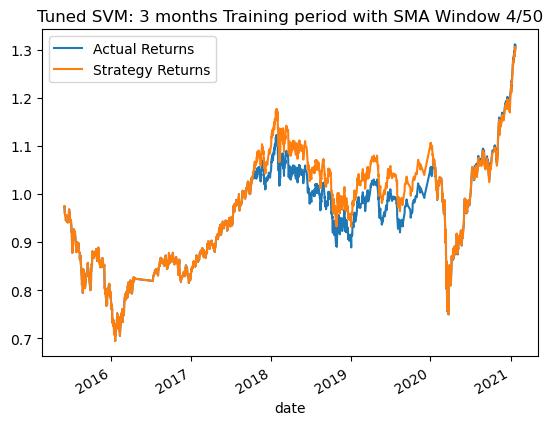

In [20]:
# Plot the actual returns versus the strategy returns
svm_comparison_plot=(1 + predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot(
    title="Tuned SVM: 3 months Training period with SMA Window 4/50")
svm_comparison_plot.get_figure().savefig("SVM_Tuned.png",bbox_inches="tight")


### Step 1:  Import a new classifier, such as `AdaBoost`, `DecisionTreeClassifier`, or `LogisticRegression`. (For the full list of classifiers, refer to the [Supervised learning page](https://scikit-learn.org/stable/supervised_learning.html) in the scikit-learn documentation.)

In [21]:
# Import a new classifier from SKLearn
from sklearn.linear_model import LogisticRegression

# Initiate the model instance
logistic_regression_model = LogisticRegression()

### Step 2: Using the original training data as the baseline model, fit another model with the new classifier.

In [22]:
# Fit the model using the training data
lr_model = logistic_regression_model.fit(X_train_scaled, y_train)
lr_model

LogisticRegression()

In [23]:

# Use the testing dataset to generate the predictions for the new model
lr_pred = lr_model.predict(X_test_scaled)

# Review the model's predicted values
lr_pred[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

### Step 3: Backtest the new model to evaluate its performance. 

Save a PNG image of the cumulative product of the actual returns vs. the strategy returns for this updated trading algorithm, and write your conclusions in your `README.md` file. 

Answer the following questions: 
Did this new model perform better or worse than the provided baseline model? 
Did this new model perform better or worse than your tuned trading algorithm?

In [24]:
# Use a classification report to evaluate the model using the predictions and testing data
lr_testing_report = classification_report(y_test, lr_pred)

# Print the classification report
print(lr_testing_report)

              precision    recall  f1-score   support

        -1.0       0.44      0.22      0.30      1826
         1.0       0.56      0.77      0.65      2321

    accuracy                           0.53      4147
   macro avg       0.50      0.50      0.47      4147
weighted avg       0.50      0.53      0.49      4147



In [25]:
# Create a new empty predictions DataFrame:
lr_predictions_df = pd.DataFrame(index=X_test.index)


# Add theLinear Regression model predictions to the DataFrame
# Add the SVM model predictions to the DataFrame
lr_predictions_df['Predicted'] = lr_pred

# Add the actual returns to the DataFrame
lr_predictions_df['Actual Returns'] = signals_df['Actual Returns']

# Add the strategy returns to the DataFrame
lr_predictions_df['Strategy Returns'] = lr_predictions_df['Actual Returns'] * lr_predictions_df['Predicted']

# Review the DataFrame
display(lr_predictions_df.head())
display(lr_predictions_df.tail())

,Predicted,Actual Returns,Strategy Returns
date,,,
2015-06-02 12:30:00,1.0,-0.025832,-0.025832
2015-06-02 13:45:00,1.0,0.000804,0.000804
2015-06-02 14:00:00,1.0,0.000000,0.000000
2015-06-02 14:15:00,1.0,0.000000,0.000000
2015-06-03 10:00:00,1.0,-0.007226,-0.007226


,Predicted,Actual Returns,Strategy Returns
date,,,
2021-01-22 09:30:00,-1.0,-0.006866,0.006866
2021-01-22 11:30:00,-1.0,0.002405,-0.002405
2021-01-22 13:45:00,-1.0,0.002099,-0.002099
2021-01-22 14:30:00,-1.0,0.001496,-0.001496
2021-01-22 15:45:00,-1.0,-0.000896,0.000896


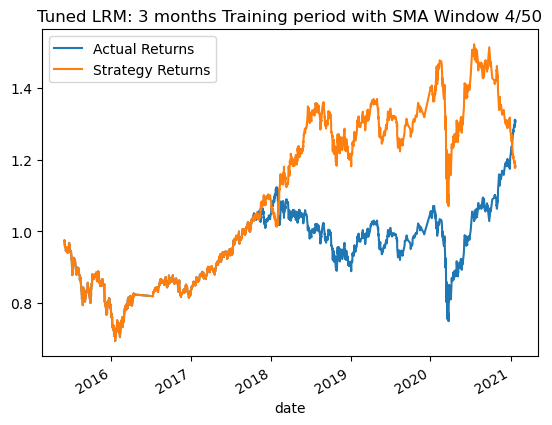

In [26]:
# Plot the actual returns versus the strategy returns
lrm_comparison_plot=(1 + lr_predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot(
    title="Tuned LRM: 3 months Training period with SMA Window 4/50")
lrm_comparison_plot.get_figure().savefig("LRM_Tuned.png",bbox_inches="tight")